In [78]:
import mlflow
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import col, when, lit, median, sum as spark_sum
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import expr
from pyspark_dist_explore import hist
from pyspark.sql.functions import count, round
from pyspark.sql import functions as F
from IPython.display import display
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import DecisionTreeClassifier

In [4]:
spark = SparkSession.builder.appName("HeartFailurePrediction").getOrCreate()

In [5]:
heart = spark.read.csv("heart.csv", header=True, inferSchema=True)

In [6]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'

In [7]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [8]:
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 1000)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 1000)
spark.conf.set("spark.sql.precision", 3)

In [9]:
heart.show(20)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [10]:
cholesterol = heart.filter(col('Cholesterol') == 0)

cholesterol.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 65|  M|          ASY|      115|          0|        0|    Normal|   93|             Y|    0.0|    Flat|           1|
| 32|  M|           TA|       95|          0|        1|    Normal|  127|             N|    0.7|      Up|           1|
| 61|  M|          ASY|      105|          0|        1|    Normal|  110|             Y|    1.5|      Up|           1|
| 50|  M|          ASY|      145|          0|        1|    Normal|  139|             Y|    0.7|    Flat|           1|
| 57|  M|          ASY|      110|          0|        1|        ST|  131|             Y|    1.4|      Up|           1|
| 51|  M|          ASY|      110|          0|        1| 

In [11]:
num_rows = cholesterol.count()

num_columns = len(cholesterol.columns)

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 172
Number of Columns: 12


In [12]:
max_hr = heart.filter(col('MaxHR') == 0)

max_hr.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



In [13]:
heart = heart.withColumn('Cholesterol', when(col('Cholesterol') == 0, None).otherwise(col('Cholesterol')))

heart.show(1)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
only showing top 1 row



In [14]:
median_value = heart.select(median(col("Cholesterol"))).collect()[0][0]
heart = heart.withColumn("Cholesterol", when(col("Cholesterol").isNull(), lit(median_value)).otherwise(col("Cholesterol")))
heart.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|      289.0|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|      180.0|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|      283.0|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|      214.0|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|      195.0|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|      339.0|        0| 

In [15]:
resting_bp = heart.filter(col('RestingBP') == 0)

resting_bp.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 55|  M|          NAP|        0|      237.0|        0|    Normal|  155|             N|    1.5|    Flat|           1|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



In [16]:
filtered_heart = heart.filter(col('RestingBP') != 0)

heart = filtered_heart

heart.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.


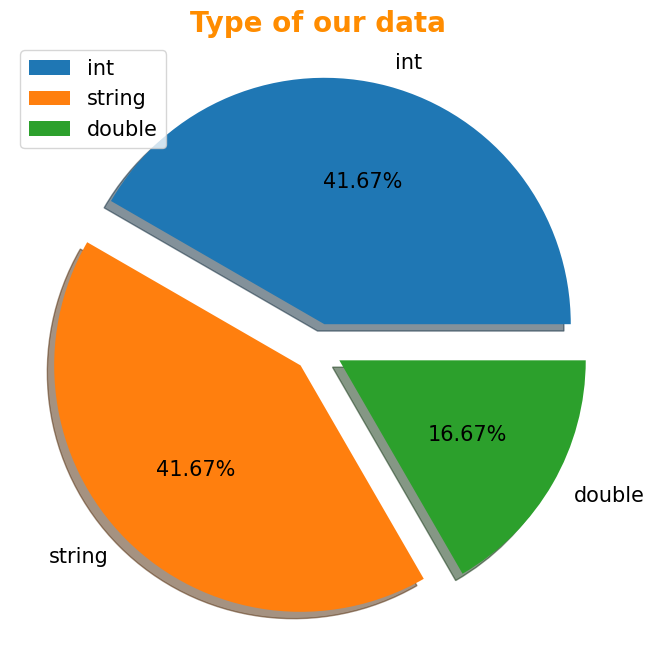

In [17]:
data_types = [dtype[1] for dtype in heart.dtypes]

data_type_counts = {}
for dtype in data_types:
    data_type_counts[dtype] = data_type_counts.get(dtype, 0) + 1

data_types = list(data_type_counts.keys())
counts = list(data_type_counts.values())

explode = [0.1] * len(data_types)
plt.figure(figsize=(8, 8))
plt.pie(counts, explode=explode, labels=data_types, autopct='%1.2f%%', shadow=True)
plt.title('Type of our data', fontsize=20, color='DarkOrange', fontweight='bold', fontname='Lucida Calligraphy')
plt.legend(labels=data_types)
plt.axis('off')
plt.show()

In [18]:
heart.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [19]:
numerical = []
for col_name, col_type in heart.dtypes:
    if col_type in (IntegerType(), DoubleType()):
        numerical.append(col_name)

print(numerical)

[]


In [20]:
categorical = []
for col_name, col_type in heart.dtypes:
    if col_type == StringType():
        categorical.append(col_name)

print(categorical)

[]


In [21]:
null_counts = heart.select([col(column).isNull().alias(column) for column in heart.columns])\
                  .groupBy().sum().collect()

for column, count in zip(heart.columns, null_counts[0]):
    print(f"{column}: {count}")

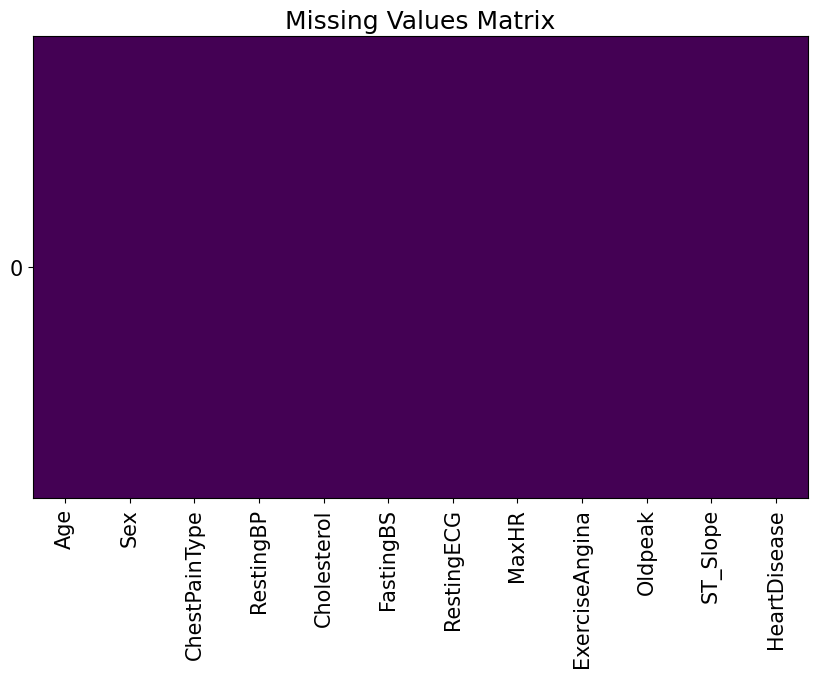

In [22]:
missing_data = heart.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in heart.columns])

missing_df = missing_data.toPandas()

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(missing_df.isnull(), cmap="viridis", aspect="auto")

ax.set_xticks(range(len(missing_df.columns)))
ax.set_xticklabels(missing_df.columns, rotation=90)
ax.set_yticks(range(len(missing_df)))
ax.set_yticklabels(missing_df.index)

plt.title("Missing Values Matrix")
plt.show()

In [23]:
for col in heart.columns:
    print(col)

Age
Sex
ChestPainType
RestingBP
Cholesterol
FastingBS
RestingECG
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
HeartDisease


In [24]:
filtered_heart = heart.filter(col("HeartDisease") == 0)

statistics = filtered_heart.describe().cache()

statistics_transposed = statistics.select(*([lit('mean').alias('summary')] + [
    (col(c).cast('double')).alias(c) for c in statistics.columns[1:]
])).union(
    statistics.select(*([lit('std').alias('summary')] + [
        (col(c).cast('double')).alias(c) for c in statistics.columns[1:]
    ]))
).union(
    statistics.select(*([lit('50%').alias('summary')] + [
        (col(c).cast('double')).alias(c) for c in statistics.columns[1:]
    ]))
).union(
    statistics.select(*([lit('count').alias('summary')] + [
        (col(c).cast('double')).alias(c) for c in statistics.columns[1:]
    ]))
)


statistics_transposed.show()


+-------+------------------+-----+-------------+------------------+-----------------+-------------------+----------+------------------+--------------+-------------------+--------+------------+
|summary|               Age|  Sex|ChestPainType|         RestingBP|      Cholesterol|          FastingBS|RestingECG|             MaxHR|ExerciseAngina|            Oldpeak|ST_Slope|HeartDisease|
+-------+------------------+-----+-------------+------------------+-----------------+-------------------+----------+------------------+--------------+-------------------+--------+------------+
|   mean|             410.0|410.0|        410.0|             410.0|            410.0|              410.0|     410.0|             410.0|         410.0|              410.0|   410.0|       410.0|
|   mean|50.551219512195125| null|         null|130.18048780487806|238.6829268292683| 0.1073170731707317|      null|148.15121951219513|          null|0.40804878048780474|    null|         0.0|
|   mean|  9.44491485414576| null| 

In [25]:
filtered_heart = heart.filter(col("HeartDisease") == 1)

statistics = filtered_heart.describe().cache()

statistics_transposed = statistics.select(*([lit('mean').alias('summary')] + [
    (col(c).cast('double')).alias(c) for c in statistics.columns[1:]
])).union(
    statistics.select(*([lit('std').alias('summary')] + [
        (col(c).cast('double')).alias(c) for c in statistics.columns[1:]
    ]))
).union(
    statistics.select(*([lit('50%').alias('summary')] + [
        (col(c).cast('double')).alias(c) for c in statistics.columns[1:]
    ]))
).union(
    statistics.select(*([lit('count').alias('summary')] + [
        (col(c).cast('double')).alias(c) for c in statistics.columns[1:]
    ]))
)


statistics_transposed.show()

+-------+-----------------+-----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+------------+
|summary|              Age|  Sex|ChestPainType|         RestingBP|       Cholesterol|          FastingBS|RestingECG|             MaxHR|ExerciseAngina|           Oldpeak|ST_Slope|HeartDisease|
+-------+-----------------+-----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+------------+
|   mean|            507.0|507.0|        507.0|             507.0|             507.0|              507.0|     507.0|             507.0|         507.0|             507.0|   507.0|       507.0|
|   mean|55.90138067061144| null|         null|134.44970414201183|246.87376725838266|0.33530571992110453|      null|127.60157790927022|          null|1.2737672583826432|    null|         1.0|
|   mean|8.735583157966282| null|       

In [27]:
summary = heart.describe()

min_values = summary.filter(col("summary") == "min")

min_values_list = min_values.collect()

def highlight_min_value(column_name, value):
    if isinstance(value, float):
        return when(col(column_name) == value, True).otherwise(False)
    else:
        return lit(False)

highlight_exprs = [
    highlight_min_value(column_name, float(row[column_name]))
    for row in min_values_list
    for column_name, dtype in zip(summary.columns[1:], heart.dtypes)
    if dtype[1] in ("int", "double") 
]

highlighted_heart = heart.withColumn("highlight", lit(0))
for expr in highlight_exprs:
    highlighted_heart = highlighted_heart.withColumn(
        "highlight", when(expr, 1).otherwise(col("highlight"))
    )

highlighted_heart.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+---------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|highlight|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+---------+
| 40|  M|          ATA|      140|      289.0|        0|    Normal|  172|             N|    0.0|      Up|           0|        1|
| 49|  F|          NAP|      160|      180.0|        0|    Normal|  156|             N|    1.0|    Flat|           1|        1|
| 37|  M|          ATA|      130|      283.0|        0|        ST|   98|             N|    0.0|      Up|           0|        1|
| 48|  F|          ASY|      138|      214.0|        0|    Normal|  108|             Y|    1.5|    Flat|           1|        1|
| 54|  M|          NAP|      150|      195.0|        0|    Normal|  122|             N|    0.0|      Up|

In [28]:
categorical_columns = [column for column, dtype in heart.dtypes if dtype == "string"]

categorical_summary = heart
for column in categorical_columns:
    categorical_summary = categorical_summary.withColumn(f"Missing_{column}", col(column).isNull().cast("int"))
    categorical_summary = categorical_summary.withColumn(f"Count_{column}_F", (col(column) == "F").cast("int"))
    categorical_summary = categorical_summary.withColumn(f"Count_{column}_M", (col(column) == "M").cast("int"))
    categorical_summary = categorical_summary.withColumn(f"Count_{column}_Yes", (col(column) == "Yes").cast("int"))
    categorical_summary = categorical_summary.withColumn(f"Count_{column}_No", (col(column) == "No").cast("int"))

categorical_summary = categorical_summary.select(*categorical_columns,
                                                 *[f"Missing_{column}" for column in categorical_columns],
                                                 *[f"Count_{column}_F" for column in categorical_columns],
                                                 *[f"Count_{column}_M" for column in categorical_columns],
                                                 *[f"Count_{column}_Yes" for column in categorical_columns],
                                                 *[f"Count_{column}_No" for column in categorical_columns])

categorical_summary.show()

+---+-------------+----------+--------------+--------+-----------+---------------------+------------------+----------------------+----------------+-----------+---------------------+------------------+----------------------+----------------+-----------+---------------------+------------------+----------------------+----------------+-------------+-----------------------+--------------------+------------------------+------------------+------------+----------------------+-------------------+-----------------------+-----------------+
|Sex|ChestPainType|RestingECG|ExerciseAngina|ST_Slope|Missing_Sex|Missing_ChestPainType|Missing_RestingECG|Missing_ExerciseAngina|Missing_ST_Slope|Count_Sex_F|Count_ChestPainType_F|Count_RestingECG_F|Count_ExerciseAngina_F|Count_ST_Slope_F|Count_Sex_M|Count_ChestPainType_M|Count_RestingECG_M|Count_ExerciseAngina_M|Count_ST_Slope_M|Count_Sex_Yes|Count_ChestPainType_Yes|Count_RestingECG_Yes|Count_ExerciseAngina_Yes|Count_ST_Slope_Yes|Count_Sex_No|Count_ChestPainT

In [29]:
string_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="keep")
            for col_name in string_cols]

encoder = OneHotEncoder(inputCols=[col_name + "_index" for col_name in string_cols],
                        outputCols=[col_name + "_encoded" for col_name in string_cols])

feature_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"] + [col_name + "_encoded" for col_name in string_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


pipeline = Pipeline(stages=indexers + [encoder, assembler])
pipeline_model = pipeline.fit(heart)
encoded_heart = pipeline_model.transform(heart)

heart_vectorized = encoded_heart.select("features")
correlation_matrix = Correlation.corr(heart_vectorized, "features").head()[0]

correlation_df = spark.createDataFrame(
    correlation_matrix.toArray().tolist(),
    schema=["feature1", "feature2", "correlation"]
)

sorted_correlation_df = correlation_df \
    .withColumn("correlation", col("correlation").cast("double")) \
    .orderBy("correlation", ascending=False)

sorted_correlation_df.show()


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            feature1|            feature2|         correlation|                  _4|                  _5|                  _6|                  _7|                  _8|                  _9|                 _10|                 _11|                 _12|                 _13|                 _14|                 _15|                 _16|                 _17|                 _18|                 _19|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------

In [30]:
string_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="keep")
            for col_name in string_cols]

encoder = OneHotEncoder(inputCols=[col_name + "_index" for col_name in string_cols],
                        outputCols=[col_name + "_encoded" for col_name in string_cols])

feature_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"] + [col_name + "_encoded" for col_name in string_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


pipeline = Pipeline(stages=indexers + [encoder, assembler])
pipeline_model = pipeline.fit(heart)
encoded_heart = pipeline_model.transform(heart)

correlation_matrix = Correlation.corr(encoded_heart, "features").head()[0]

correlation_df = spark.createDataFrame(
    correlation_matrix.toArray().tolist(),
    schema=encoded_heart.columns[-1:]
)

correlation_df.show(truncate=False)

+---------------------+---------------------+----------------------+----------------------+--------------------+----------------------+---------------------+---------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+--------------------+--------------------+---------------------+---------------------+---------------------+
|features             |_2                   |_3                    |_4                    |_5                  |_6                    |_7                   |_8                   |_9                   |_10                  |_11                   |_12                  |_13                  |_14                  |_15                 |_16                 |_17                  |_18                  |_19                  |
+---------------------+---------------------+----------------------+----------------------+--------------------+----------------------+---------------------+-

findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.


+-----------+--------------------+
|    Feature|         Correlation|
+-----------+--------------------+
|        Age|  0.2820117259633892|
|  RestingBP| 0.11799000562033152|
|Cholesterol| 0.07626169199449696|
|      MaxHR|-0.40140961436594785|
|    Oldpeak|  0.4036380155169544|
+-----------+--------------------+



findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.


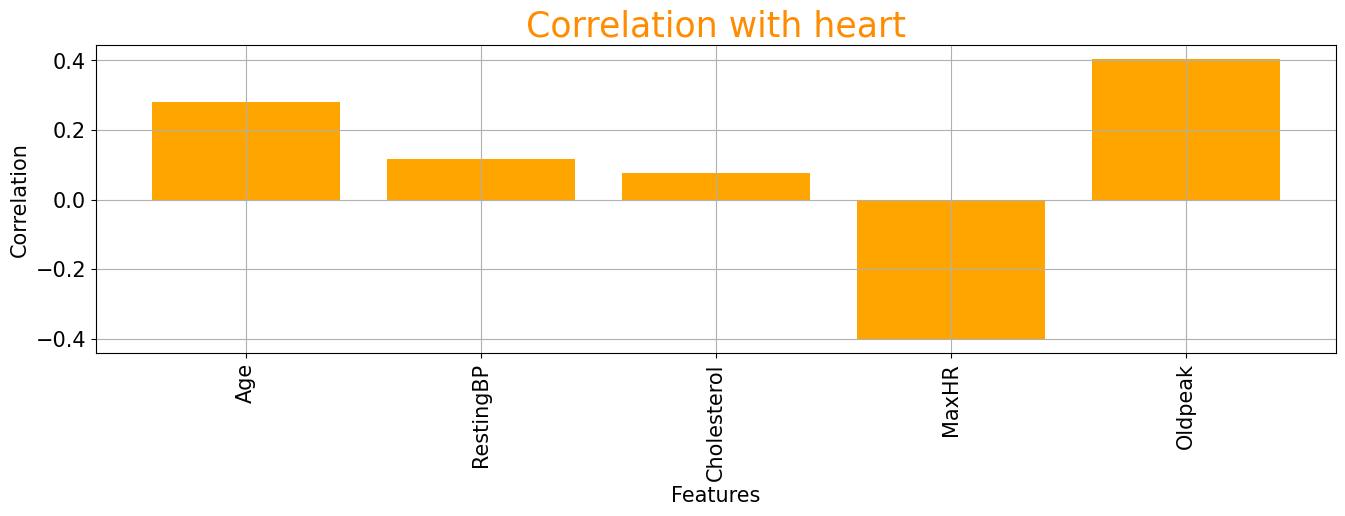

In [31]:
string_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="keep")
            for col_name in string_cols]

encoder = OneHotEncoder(inputCols=[col_name + "_index" for col_name in string_cols],
                        outputCols=[col_name + "_encoded" for col_name in string_cols])

numerical_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
assembler_numerical = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

feature_cols = ["numerical_features"] + [col_name + "_encoded" for col_name in string_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

pipeline = Pipeline(stages=indexers + [encoder, assembler_numerical, assembler])
pipeline_model = pipeline.fit(heart)
encoded_heart = pipeline_model.transform(heart)

encoded_heart = encoded_heart.drop("features", "numerical_features")

correlation_with_heart = {}
for col_name in numerical_cols:
    correlation = encoded_heart.stat.corr(col_name, "HeartDisease")
    correlation_with_heart[col_name] = correlation

correlation_list = [(col_name, corr) for col_name, corr in correlation_with_heart.items()]
correlation_df = spark.createDataFrame(correlation_list, schema=["Feature", "Correlation"])

correlation_df.show()

pandas_correlation_df = correlation_df.toPandas()

plt.figure(figsize=(16, 4))
plt.bar(pandas_correlation_df["Feature"], pandas_correlation_df["Correlation"], color='orange')
plt.xticks(rotation=90)
plt.title('Correlation with heart', fontsize=25, color='DarkOrange', fontname='Lucida Calligraphy')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()


findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.


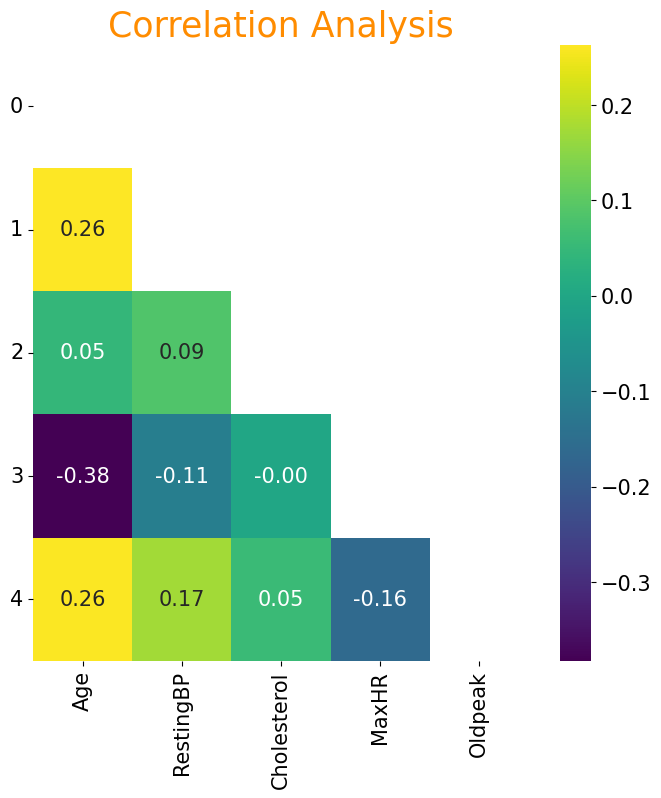

In [32]:
numerical_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
heart_vectorized = assembler.transform(heart)

correlation_matrix = Correlation.corr(heart_vectorized, "numerical_features").collect()[0][0]

corr_df = spark.createDataFrame(correlation_matrix.toArray(), numerical_cols).toPandas()
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(dpi=100)
plt.title('Correlation Analysis', fontsize=25, color='DarkOrange', fontname='Lucida Calligraphy')
sns.heatmap(corr_df, mask=mask, annot=True, fmt="0.2f", cmap='viridis', lw=0, linecolor='white')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [33]:
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

for col_name in categorical_cols:
    print(f"Value counts for '{col_name}':")
    heart.groupBy(col(col_name)).count().show()
    print("****" * 10)


Value counts for 'Sex':
+---+-----+
|Sex|count|
+---+-----+
|  F|  193|
|  M|  724|
+---+-----+

****************************************
Value counts for 'ChestPainType':
+-------------+-----+
|ChestPainType|count|
+-------------+-----+
|          NAP|  202|
|          ATA|  173|
|           TA|   46|
|          ASY|  496|
+-------------+-----+

****************************************
Value counts for 'RestingECG':
+----------+-----+
|RestingECG|count|
+----------+-----+
|       LVH|  188|
|    Normal|  551|
|        ST|  178|
+----------+-----+

****************************************
Value counts for 'ExerciseAngina':
+--------------+-----+
|ExerciseAngina|count|
+--------------+-----+
|             Y|  371|
|             N|  546|
+--------------+-----+

****************************************
Value counts for 'ST_Slope':
+--------+-----+
|ST_Slope|count|
+--------+-----+
|    Flat|  459|
|      Up|  395|
|    Down|   63|
+--------+-----+

****************************************

In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr


numerical_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]  # Update the ST_Depression to Oldpeak

skew_limit = 0.75

skew_vals = heart.agg(*(expr('skewness({}) as {}'.format(col, col)) for col in numerical_cols)).collect()[0].asDict()

skew_cols = {col: skew_vals[col] for col in numerical_cols if abs(skew_vals[col]) > skew_limit}
skew_cols = sorted(skew_cols.items(), key=lambda x: x[1], reverse=True)

for col, skewness in skew_cols:
    print(f"{col}: {skewness}")


Cholesterol: 1.443496892197544
Oldpeak: 1.0228679540445653


In [35]:
pip install pyspark_dist_explore

Note: you may need to restart the kernel to use updated packages.


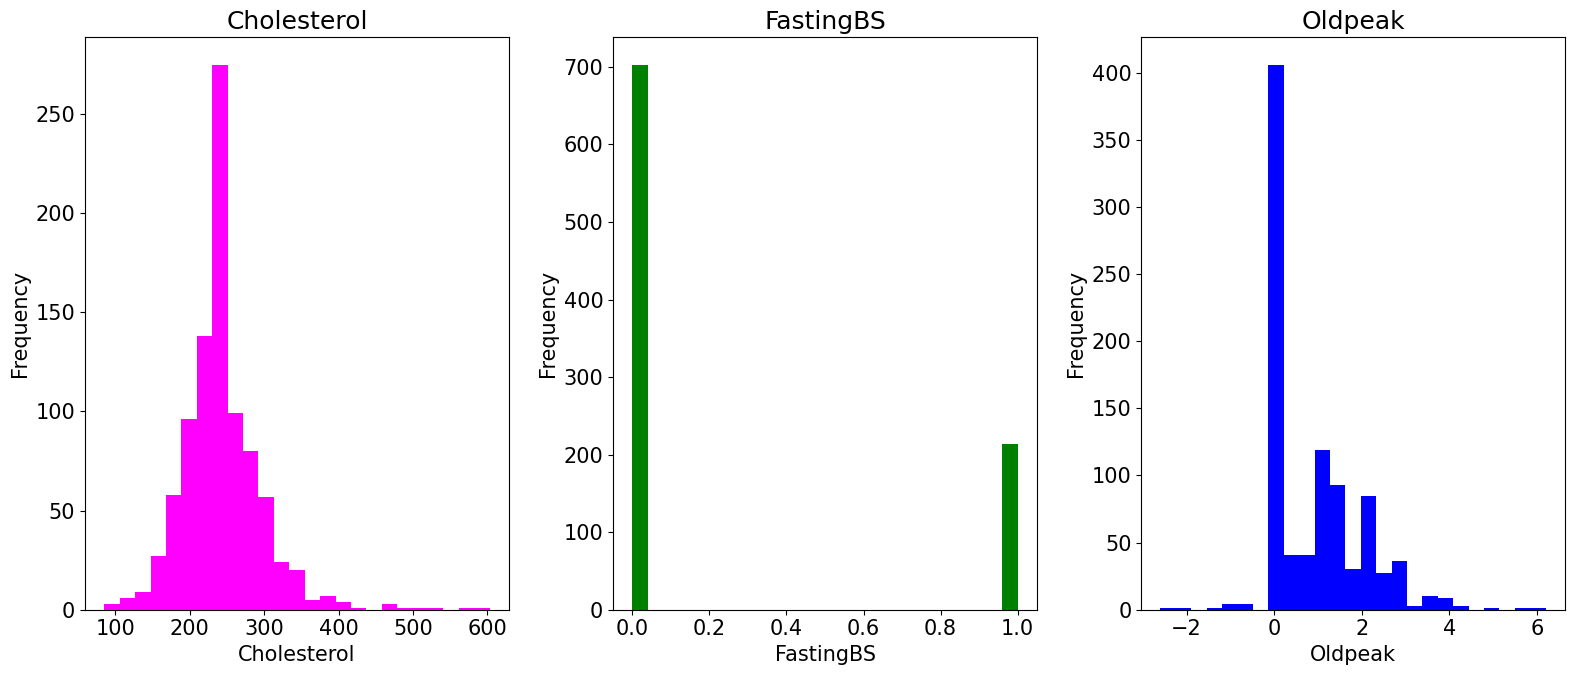

In [36]:
import matplotlib.pyplot as plt
from pyspark_dist_explore import hist
from pyspark.sql.functions import col


plt.figure(figsize=(16, 7))

plt.subplot(131)
plt.hist(heart.select("Cholesterol").rdd.flatMap(lambda x: x).collect(), bins=25, color="magenta")
plt.title('Cholesterol')
plt.xlabel("Cholesterol")
plt.ylabel("Frequency")

plt.subplot(132)
plt.hist(heart.select("FastingBS").rdd.flatMap(lambda x: x).collect(), bins=25, color="green")
plt.title('FastingBS')
plt.xlabel("FastingBS")
plt.ylabel("Frequency")

plt.subplot(133)
plt.hist(heart.select("Oldpeak").rdd.flatMap(lambda x: x).collect(), bins=25, color="blue")
plt.title('Oldpeak')
plt.xlabel("Oldpeak")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [37]:
def percent_counts(df, feature):
    total_counts = df.groupBy(feature).agg(count("*").alias("Total"))
    total_records = df.count()
    percent_counts = total_counts.withColumn("Percentage", round(col("Total") / total_records * 100, 2))
    
    return percent_counts

In [38]:
result = percent_counts(heart, "Cholesterol")

result.show()

+-----------+-----+----------+
|Cholesterol|Total|Percentage|
+-----------+-----+----------+
|      305.0|    4|      0.44|
|      299.0|    2|      0.22|
|      184.0|    4|      0.44|
|      147.0|    2|      0.22|
|      170.0|    2|      0.22|
|      160.0|    6|      0.65|
|      169.0|    2|      0.22|
|      311.0|    2|      0.22|
|      168.0|    2|      0.22|
|      206.0|    3|      0.33|
|      365.0|    1|      0.11|
|      249.0|    5|      0.55|
|      142.0|    1|      0.11|
|      329.0|    1|      0.11|
|      232.0|    3|      0.33|
|      303.0|    4|      0.44|
|      253.0|    4|      0.44|
|      331.0|    1|      0.11|
|      201.0|    6|      0.65|
|      235.0|    5|      0.55|
+-----------+-----+----------+
only showing top 20 rows



In [39]:
def percent_counts(df, feature):
    total_counts = df.groupBy(feature).agg(count("*").alias("Total"))
    total_records = df.count()
    percent_counts = total_counts.withColumn("Percentage", round(col("Total") / total_records * 100, 2))
    
    return percent_counts

In [40]:
result = percent_counts(heart, 'Sex')
result_pd = result.toPandas()

styled_result = result_pd.style.background_gradient(cmap='coolwarm').set_precision(2)

styled_result

/tmp/ipykernel_3101/1102230461.py:10: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  styled_result = result_pd.style.background_gradient(cmap='coolwarm').set_precision(2)


,Sex,Total,Percentage
0,F,193,21.05
1,M,724,78.95


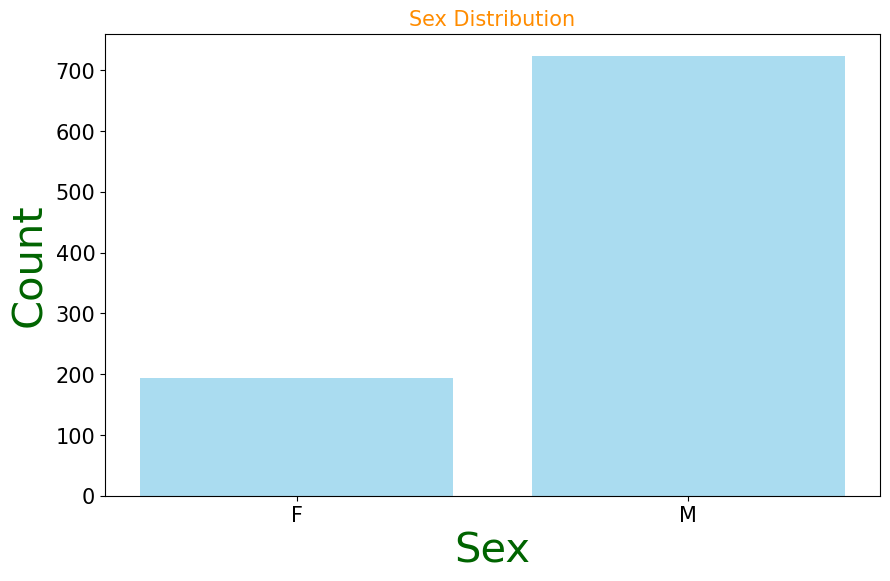

In [41]:
sex_counts = heart.groupBy('Sex').agg(count('*').alias('Count'))
sex_counts_pd = sex_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(sex_counts_pd['Sex'], sex_counts_pd['Count'], color='skyblue', alpha=0.7)
plt.title('Sex Distribution', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')
plt.xlabel('Sex', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')
plt.ylabel('Count', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')

plt.show()

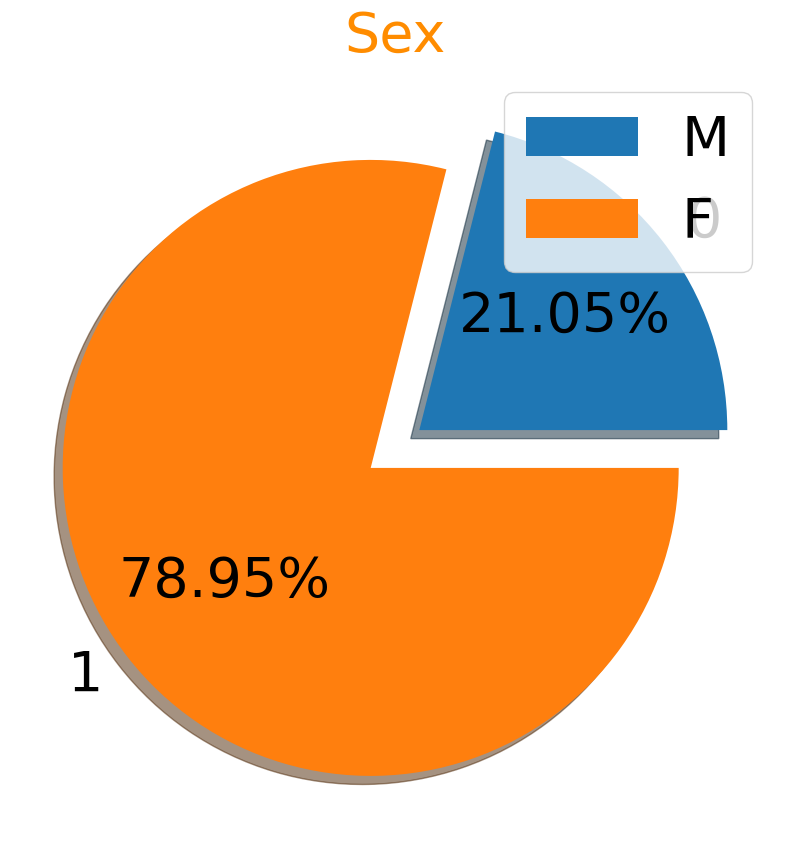

In [42]:
sex_counts = heart.groupBy('Sex').agg(count('*').alias('Count'))

sex_counts_pd = sex_counts.toPandas()

plt.rcParams.update({'font.size': 40})

plt.figure(figsize=(10, 10))
ax = sex_counts_pd['Count'].plot.pie(explode=[0.1, 0.1], autopct='%1.2f%%', shadow=True)
ax.set_title("Sex", fontsize=40, color='DarkOrange', font='Lucida Calligraphy')
plt.legend(labels=['M', 'F'])
plt.axis('off')

plt.show()

In [43]:
def percent_counts(df, feature):
    total_counts = df.groupBy(feature).agg(count('*').alias('Total'))
    percent_counts = df.groupBy(feature).agg(round((count('*') / df.count()) * 100, 2).alias('Percentage'))
    
    result = total_counts.join(percent_counts, on=feature)
    result_pd = result.toPandas()
    
    return result_pd

chest_pain_percent_counts = percent_counts(heart, 'ChestPainType')

chest_pain_percent_counts.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_3101/379936201.py:16: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  chest_pain_percent_counts.style.background_gradient(cmap='coolwarm').set_precision(2)


,ChestPainType,Total,Percentage
0,NAP,202,22.03
1,ATA,173,18.87
2,TA,46,5.02
3,ASY,496,54.09


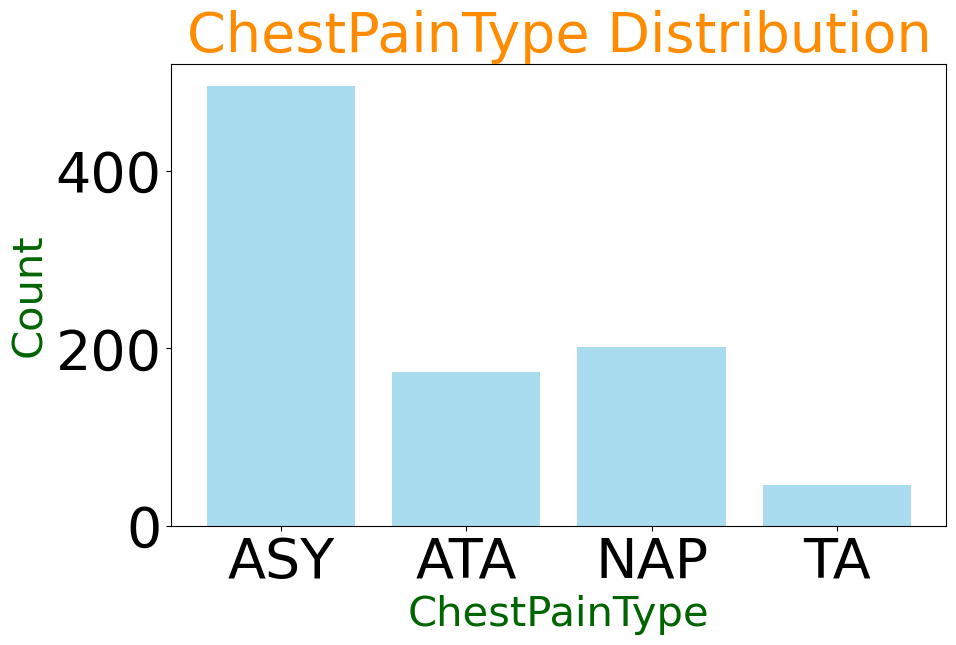

In [45]:
chest_pain_counts = heart.groupBy('ChestPainType').count().orderBy('ChestPainType')

chest_pain_types = chest_pain_counts.select('ChestPainType').rdd.flatMap(lambda x: x).collect()
chest_pain_counts = chest_pain_counts.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.bar(chest_pain_types, chest_pain_counts, color='skyblue', alpha=0.7)
plt.title('ChestPainType Distribution', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')
plt.xlabel('ChestPainType', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')
plt.ylabel('Count', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')

plt.show()

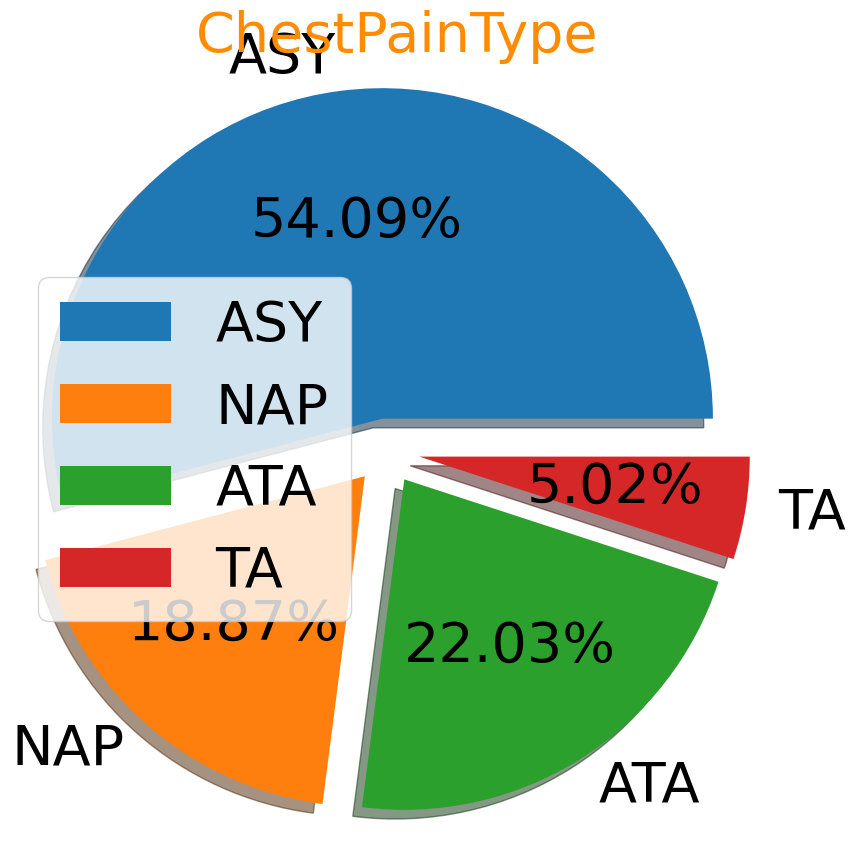

In [46]:
chest_pain_counts = heart.groupBy('ChestPainType').agg(count('*').alias('Count')).orderBy('ChestPainType')

chest_pain_counts_pd = chest_pain_counts.toPandas()

plt.figure(figsize=(10, 10))
explode = [0.1, 0.1, 0.1, 0.1]
plt.pie(chest_pain_counts_pd['Count'], labels=['ASY', 'NAP', 'ATA', 'TA'], explode=explode, autopct='%1.2f%%', shadow=True)
plt.title('ChestPainType', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')

plt.axis('equal')
plt.legend(labels=['ASY', 'NAP', 'ATA', 'TA'])
plt.show()

In [47]:
from pyspark.sql.functions import col, count, round

def percent_counts(df, feature):
    
    total_counts = df.groupBy(feature).agg(count('*').alias('Total'))
    total_counts_pd = total_counts.toPandas()
    total_counts_pd.set_index(feature, inplace=True)

    total_counts_pd['Percentage'] = (total_counts_pd['Total'] / df.count()) * 100
    total_counts_pd['Percentage'] = total_counts_pd['Percentage'].round(2)
    
    total_counts_pd = total_counts_pd.sort_values(by='Total', ascending=False)

    return total_counts_pd

In [48]:
resting_ecg_counts = percent_counts(heart, 'RestingECG')
resting_ecg_counts.style.background_gradient(cmap='coolwarm').set_precision(2)


/tmp/ipykernel_3101/3619607633.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  resting_ecg_counts.style.background_gradient(cmap='coolwarm').set_precision(2)


,Total,Percentage
RestingECG,,
Normal,551,60.09
LVH,188,20.50
ST,178,19.41


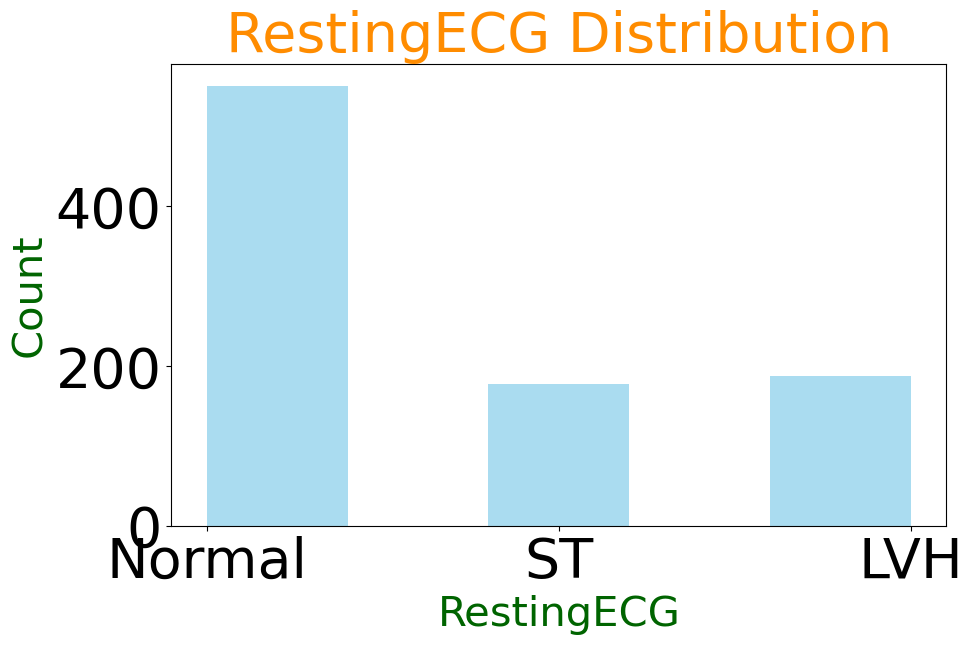

In [49]:
heart_pd = heart.select("RestingECG").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(heart_pd['RestingECG'], bins=5, color='skyblue', alpha=0.7)
plt.title('RestingECG Distribution', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')
plt.xlabel('RestingECG', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')
plt.ylabel('Count', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')

plt.show()

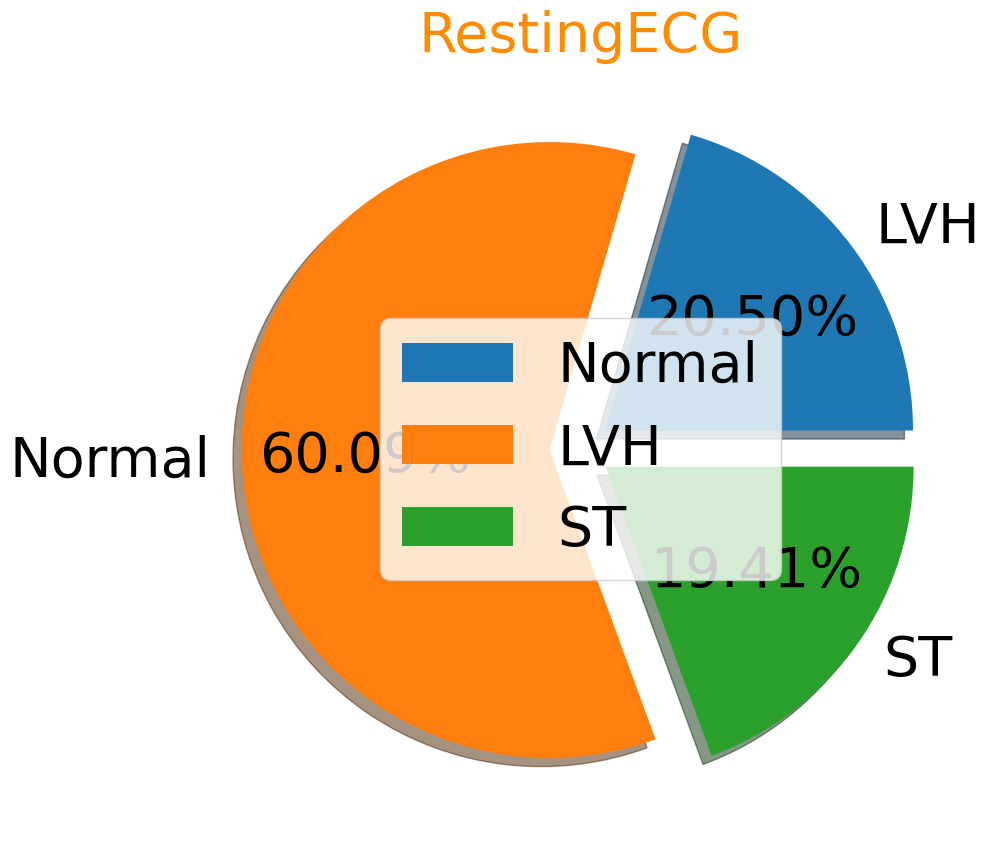

In [50]:
resting_ecg_counts = heart.groupBy('RestingECG').count().orderBy('RestingECG')

resting_ecg_counts_pd = resting_ecg_counts.toPandas()

plt.figure(figsize=(10, 10))
plt.pie(resting_ecg_counts_pd['count'], labels=resting_ecg_counts_pd['RestingECG'], explode=[0.1, 0.1, 0.1], autopct='%1.2f%%', shadow=True)
plt.title('RestingECG', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')
plt.legend(labels=['Normal', 'LVH', 'ST'])
plt.axis('off')

plt.show()

In [51]:
exercise_angina_counts = heart.groupBy('ExerciseAngina').count()
total_rows = heart.count()
exercise_angina_counts = exercise_angina_counts.withColumn('Percentage', F.round(exercise_angina_counts['count'] / total_rows * 100, 2))

exercise_angina_counts_pd = exercise_angina_counts.toPandas()

exercise_angina_counts_pd.rename(columns={'ExerciseAngina': 'Value', 'count': 'Total', 'Percentage': 'Percentage'}, inplace=True)
exercise_angina_counts_pd['Percentage'] = exercise_angina_counts_pd['Percentage'].map('{:.2f}%'.format)
exercise_angina_counts_pd['Percentage'] = exercise_angina_counts_pd['Percentage'].str.replace('%', '').astype(float)  # Remove '%' and convert to float

exercise_angina_counts_pd.style.background_gradient(cmap='coolwarm', subset=['Total', 'Percentage'], low=0, high=100)


,Value,Total,Percentage
0,Y,371,40.460000
1,N,546,59.540000


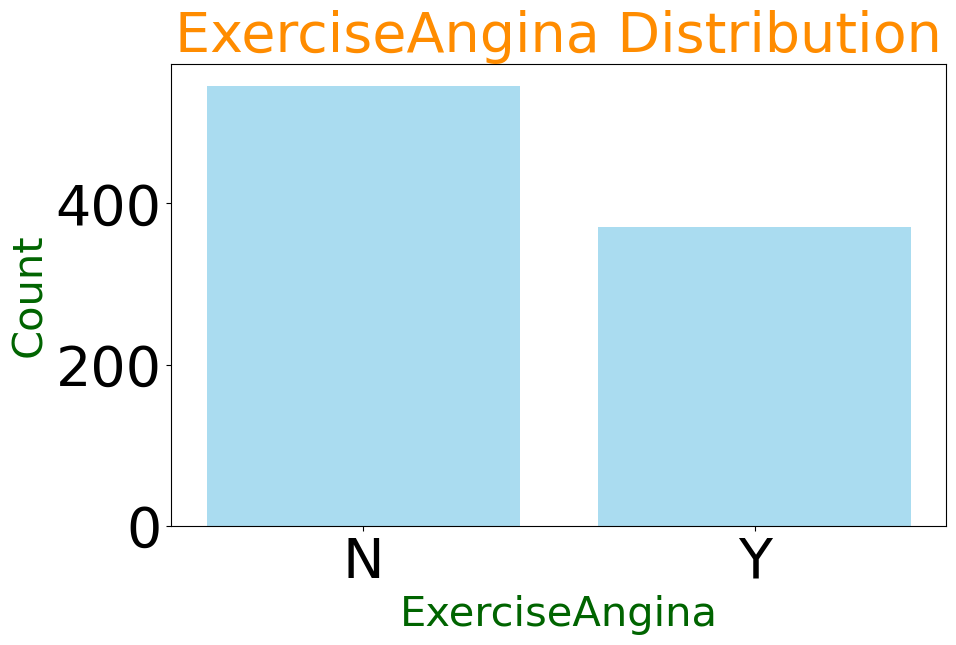

In [52]:
exercise_angina_counts = heart.groupBy('ExerciseAngina').count().orderBy('ExerciseAngina')

exercise_angina_counts_pd = exercise_angina_counts.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(exercise_angina_counts_pd['ExerciseAngina'], exercise_angina_counts_pd['count'], color='skyblue', alpha=0.7)
plt.title('ExerciseAngina Distribution', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')
plt.xlabel('ExerciseAngina', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')
plt.ylabel('Count', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')

plt.show()

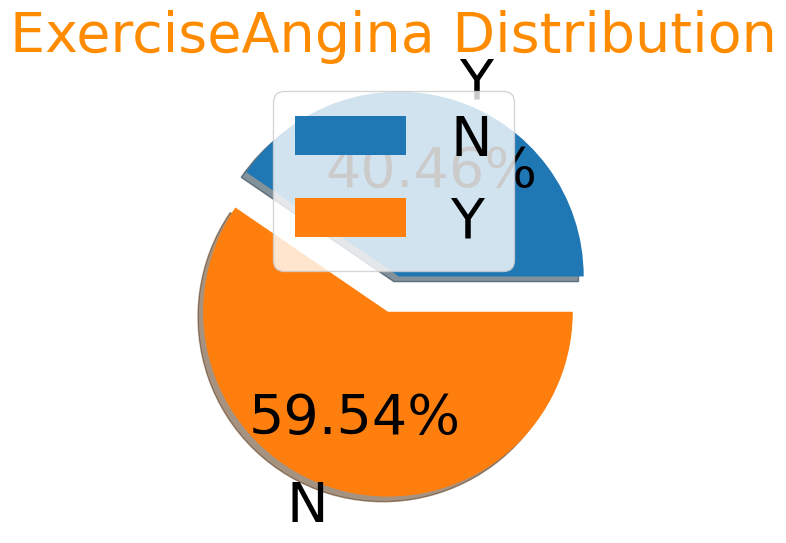

In [53]:
exercise_angina_counts = heart.groupBy('ExerciseAngina').count()

exercise_angina_counts_pd = exercise_angina_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.pie(exercise_angina_counts_pd['count'], labels=exercise_angina_counts_pd['ExerciseAngina'], explode=[0.1, 0.1], autopct='%1.2f%%', shadow=True)
plt.title('ExerciseAngina Distribution', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')

plt.axis('off')
plt.legend(labels=['N', 'Y'])
plt.show()

In [54]:
st_slope_counts = heart.groupBy('ST_Slope').count()
total_rows = heart.count()
st_slope_counts = st_slope_counts.withColumn('Percentage', F.round(st_slope_counts['count'] / total_rows * 100, 2))

st_slope_counts_pd = st_slope_counts.toPandas()

st_slope_counts_pd.rename(columns={'ST_Slope': 'Value'}, inplace=True)
st_slope_counts_pd['Percentage'] = st_slope_counts_pd['Percentage'].apply(lambda x: "{:.2f}%".format(x))
st_slope_counts_pd['Percentage'] = st_slope_counts_pd['Percentage'].str.replace('%', '').astype(float)  # Remove '%' and convert to float

display(st_slope_counts_pd.style.background_gradient(cmap='coolwarm', subset=['count', 'Percentage'], low=0, high=100))


,Value,count,Percentage
0,Flat,459,50.050000
1,Up,395,43.080000
2,Down,63,6.870000


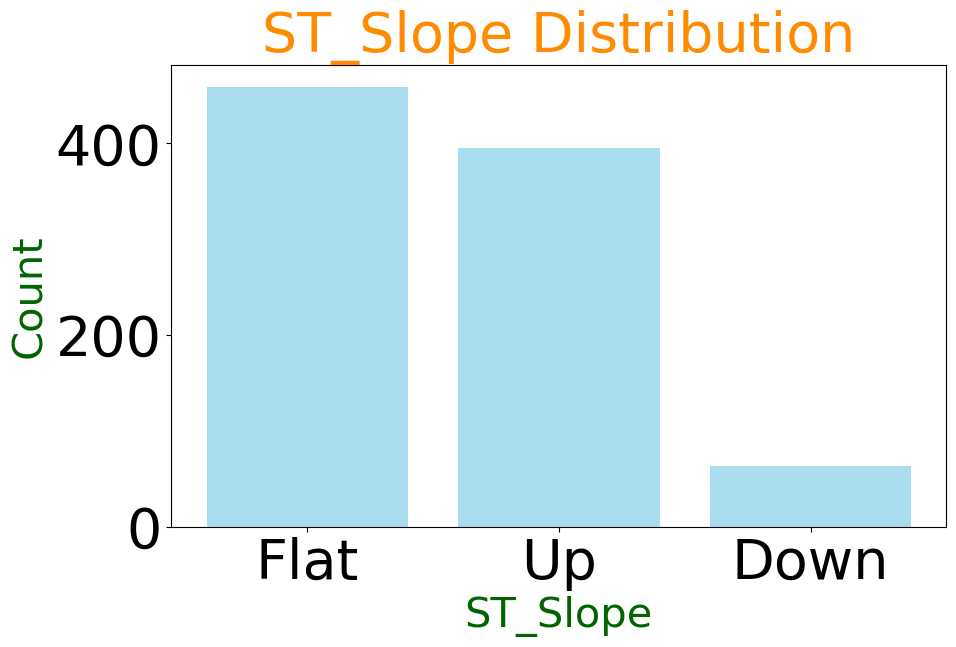

In [55]:
st_slope_counts = heart.groupBy('ST_Slope').count()

st_slope_counts_pd = st_slope_counts.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(st_slope_counts_pd['ST_Slope'], st_slope_counts_pd['count'], color='skyblue', alpha=0.7)
plt.title('ST_Slope Distribution', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')
plt.xlabel('ST_Slope', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')
plt.ylabel('Count', fontsize=30, color='DarkGreen', font='Lucida Calligraphy')

plt.show()

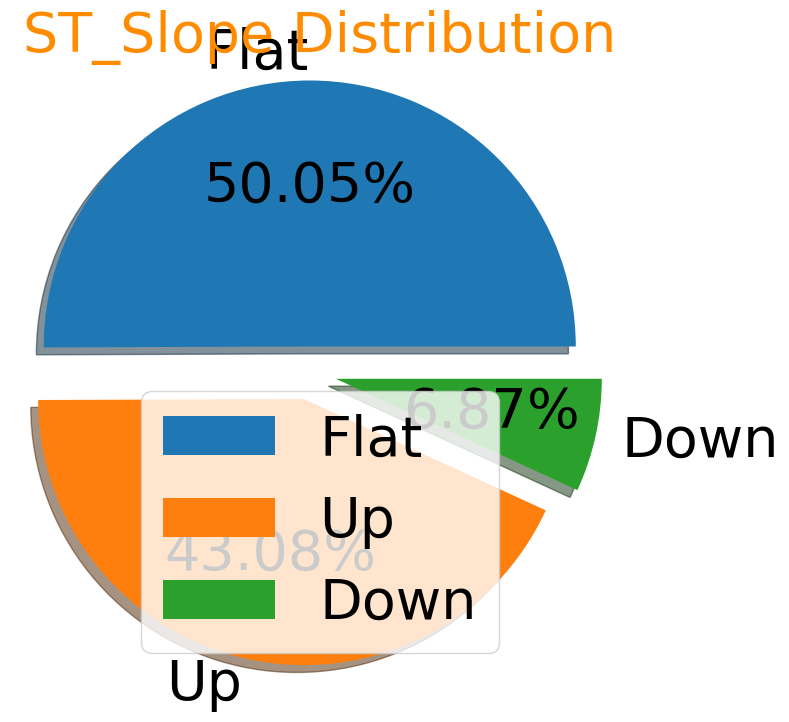

In [56]:
st_slope_counts = heart.groupBy('ST_Slope').count()

st_slope_counts_pd = st_slope_counts.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(st_slope_counts_pd['count'], labels=st_slope_counts_pd['ST_Slope'], explode=[0.1, 0.1, 0.1], autopct='%1.2f%%', shadow=True)
plt.title('ST_Slope Distribution', fontsize=40, color='DarkOrange', font='Lucida Calligraphy')
plt.legend(labels=['Flat', 'Up', 'Down'])
plt.axis('equal')  

plt.show()

In [57]:
def multi_table(table_list):
    for table in table_list:
        display(table)

variables = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

df_groupby = {var: heart.groupBy(var, 'HeartDisease').count().alias('Count')
              for var in variables}

df_groupby_pd = {var: df_groupby[var].toPandas() for var in variables}


multi_table([df_groupby_pd['ChestPainType'], df_groupby_pd['Sex'], df_groupby_pd['RestingECG'], 
             df_groupby_pd['ExerciseAngina'], df_groupby_pd['ST_Slope']])


,ChestPainType,HeartDisease,count
0,TA,1,20
1,ASY,1,392
2,NAP,1,71
3,TA,0,26
4,ASY,0,104
5,ATA,0,149
6,NAP,0,131
7,ATA,1,24


,Sex,HeartDisease,count
0,M,1,457
1,F,0,143
2,F,1,50
3,M,0,267


,RestingECG,HeartDisease,count
0,ST,0,61
1,ST,1,117
2,LVH,1,106
3,Normal,0,267
4,Normal,1,284
5,LVH,0,82


,ExerciseAngina,HeartDisease,count
0,N,1,191
1,Y,1,316
2,Y,0,55
3,N,0,355


,ST_Slope,HeartDisease,count
0,Flat,1,380
1,Down,1,49
2,Up,1,78
3,Down,0,14
4,Up,0,317
5,Flat,0,79


In [58]:
heart.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|      289.0|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|      180.0|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|      283.0|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|      214.0|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|      195.0|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|      339.0|        0| 

In [59]:
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]
indexers_model = [indexer.fit(heart) for indexer in indexers]
heart_indexed = heart
for model in indexers_model:
    heart_indexed = model.transform(heart_indexed)

encoder = OneHotEncoder(inputCols=[col + "_index" for col in ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']],
                        outputCols=[col + "_encoded" for col in ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']])
heart_encoded = encoder.fit(heart_indexed).transform(heart_indexed)

heart_encoded.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+---------+-------------------+----------------+--------------------+--------------+-------------+---------------------+------------------+----------------------+----------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|Sex_index|ChestPainType_index|RestingECG_index|ExerciseAngina_index|ST_Slope_index|  Sex_encoded|ChestPainType_encoded|RestingECG_encoded|ExerciseAngina_encoded|ST_Slope_encoded|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+---------+-------------------+----------------+--------------------+--------------+-------------+---------------------+------------------+----------------------+----------------+
| 40|  M|          ATA|      140|      289.0|        0|    Normal|  172|             N|    0.0|      Up|        

In [60]:
heart.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [61]:
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

existing_indexed_cols = [col for col in heart.columns if col.endswith("_indexed")]

indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed") for col in categorical_cols if col + "_indexed" not in existing_indexed_cols]
for indexer in indexers:
    heart = indexer.fit(heart).transform(heart)

feature_cols = ["Age", "Sex_indexed", "ChestPainType_indexed", "RestingBP", "Cholesterol", "FastingBS", "RestingECG_indexed", "MaxHR", "ExerciseAngina_indexed", "Oldpeak", "ST_Slope_indexed"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
heart = assembler.transform(heart)

train_data, test_data = heart.randomSplit([0.8, 0.2], seed=42)

In [62]:
lr = LogisticRegression(featuresCol="features", labelCol="HeartDisease")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
log_accuracy = evaluator.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")
log_f1 = evaluator_f1.evaluate(predictions)

print("Model Accuracy Score :", log_accuracy * 100, "%")
print("F1 Score            :", log_f1 * 100, "%")
print("Confusion Matrix: \n", predictions.groupBy("HeartDisease", "prediction").count().show())
print("Classification_Report: \n")
predictions.select("HeartDisease", "prediction").show()

Model Accuracy Score : 84.45945945945947 %
F1 Score            : 84.22210452381043 %
+------------+----------+-----+
|HeartDisease|prediction|count|
+------------+----------+-----+
|           1|       0.0|    5|
|           0|       0.0|   50|
|           1|       1.0|   75|
|           0|       1.0|   18|
+------------+----------+-----+

Confusion Matrix: 
 None
Classification_Report: 

+------------+----------+
|HeartDisease|prediction|
+------------+----------+
|           0|       0.0|
|           1|       1.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
+---------

In [63]:
logreg = LogisticRegression(featuresCol="features", labelCol="HeartDisease")

param_grid = ParamGridBuilder() \
    .addGrid(logreg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logreg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease")

crossval = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

cv_model = crossval.fit(train_data)

mean_auc = cv_model.avgMetrics[0]

print("Model Average AUC: {:.2f} %".format(mean_auc * 100))

Model Average AUC: 91.35 %


In [64]:
svc = LinearSVC(labelCol="HeartDisease", featuresCol="features")

param_grid = ParamGridBuilder() \
    .addGrid(svc.maxIter, [10, 50, 100]) \
    .addGrid(svc.regParam, [0.01, 0.1, 1.0]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")

crossval = CrossValidator(estimator=svc, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

cv_model = crossval.fit(train_data)

best_model = cv_model.bestModel

predictions = best_model.transform(test_data)

accuracy = evaluator.evaluate(predictions)

print("Model Accuracy Score  : {:.2f} %".format(accuracy * 100))
print("Confusion Matrix: \n")
predictions.groupBy("HeartDisease", "prediction").count().show()
print("Classification_Report: \n")
predictions.select("HeartDisease", "prediction").show()

Model Accuracy Score  : 84.46 %
Confusion Matrix: 

+------------+----------+-----+
|HeartDisease|prediction|count|
+------------+----------+-----+
|           1|       0.0|    5|
|           0|       0.0|   50|
|           1|       1.0|   75|
|           0|       1.0|   18|
+------------+----------+-----+

Classification_Report: 

+------------+----------+
|HeartDisease|prediction|
+------------+----------+
|           0|       0.0|
|           1|       1.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
+------------+----------+
only showing top 20 rows



In [65]:
svc = LinearSVC(labelCol="HeartDisease", featuresCol="features")

param_grid = ParamGridBuilder() \
    .addGrid(svc.maxIter, [10, 50, 100]) \
    .addGrid(svc.regParam, [0.01, 0.1, 1.0]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")

crossval = CrossValidator(estimator=svc, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

cv_model = crossval.fit(train_data)

mean_accuracy = cv_model.avgMetrics[0]

print("Model Average Accuracy: {:.2f} %".format(mean_accuracy * 100))

Model Average Accuracy: 85.19 %


In [66]:
random_forest = RandomForestClassifier(featuresCol="features", labelCol="HeartDisease", numTrees=100)

model = random_forest.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions) * 100

print("Model Accuracy Score  : {:.2f} %".format(accuracy))
print("Confusion Matrix: \n", predictions.groupBy("HeartDisease", "prediction").count().show())
print("Classification_Report: \n")
predictions.select("HeartDisease", "prediction").show()

Model Accuracy Score  : 83.78 %
+------------+----------+-----+
|HeartDisease|prediction|count|
+------------+----------+-----+
|           1|       0.0|    4|
|           0|       0.0|   48|
|           1|       1.0|   76|
|           0|       1.0|   20|
+------------+----------+-----+

Confusion Matrix: 
 None
Classification_Report: 

+------------+----------+
|HeartDisease|prediction|
+------------+----------+
|           0|       0.0|
|           1|       1.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
+------------+----------+
only showing top 20 rows



In [67]:
random_forest = RandomForestClassifier(featuresCol="features", labelCol="HeartDisease", numTrees=100)

paramGrid = ParamGridBuilder()\
    .addGrid(random_forest.maxDepth, [5, 10, 15])\
    .addGrid(random_forest.minInstancesPerNode, [1, 5, 10])\
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=random_forest,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

cv_model = crossval.fit(train_data)

best_model = cv_model.bestModel
predictions = best_model.transform(test_data)

accuracy = evaluator.evaluate(predictions) * 100

print("Model Accuracy Score  : {:.2f} %".format(accuracy))

Model Accuracy Score  : 85.14 %


In [68]:
mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="HeartDisease", layers=[len(feature_cols), 10, 2])

paramGrid = ParamGridBuilder()\
    .addGrid(mlp.maxIter, [50, 100, 150])\
    .addGrid(mlp.blockSize, [32, 64, 128])\
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

cv_model = crossval.fit(train_data)

best_model = cv_model.bestModel
predictions = best_model.transform(test_data)

accuracy = evaluator.evaluate(predictions) * 100

print("Model Accuracy Score  : {:.2f} %".format(accuracy))
print("Confusion Matrix: \n", predictions.groupBy("HeartDisease", "prediction").count().show())
print("Classification_Report: \n")
predictions.select("HeartDisease", "prediction").show()

Model Accuracy Score  : 81.08 %
+------------+----------+-----+
|HeartDisease|prediction|count|
+------------+----------+-----+
|           1|       0.0|    7|
|           0|       0.0|   47|
|           1|       1.0|   73|
|           0|       1.0|   21|
+------------+----------+-----+

Confusion Matrix: 
 None
Classification_Report: 

+------------+----------+
|HeartDisease|prediction|
+------------+----------+
|           0|       0.0|
|           1|       1.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       0.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
+------------+----------+
only showing top 20 rows



In [69]:
mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="HeartDisease", layers=[len(feature_cols), 10, 2])

paramGrid = ParamGridBuilder()\
    .addGrid(mlp.maxIter, [50, 100, 150])\
    .addGrid(mlp.blockSize, [32, 64, 128])\
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

cv_model = crossval.fit(train_data)

val_score = cv_model.avgMetrics

print("Model Accuracy Score: {:.2f} %".format(sum(val_score) * 100 / len(val_score)))
print("Std. Dev: {:.2f} %".format((sum((x - (sum(val_score) / len(val_score))) ** 2 for x in val_score) / len(val_score)) ** 0.5 * 100))


Model Accuracy Score: 79.48 %
Std. Dev: 5.27 %


In [79]:
decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="HeartDisease")

model = decision_tree.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions) * 100

print("Model Accuracy Score  : {:.2f} %".format(accuracy))
print("Confusion Matrix: \n", predictions.groupBy("HeartDisease", "prediction").count().show())
print("Classification_Report: \n")
predictions.select("HeartDisease", "prediction").show()

Model Accuracy Score  : 81.08 %
+------------+----------+-----+
|HeartDisease|prediction|count|
+------------+----------+-----+
|           1|       0.0|   10|
|           0|       0.0|   50|
|           1|       1.0|   70|
|           0|       1.0|   18|
+------------+----------+-----+

Confusion Matrix: 
 None
Classification_Report: 

+------------+----------+
|HeartDisease|prediction|
+------------+----------+
|           0|       0.0|
|           1|       1.0|
|           1|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           1|       1.0|
|           0|       0.0|
|           0|       1.0|
|           0|       0.0|
|           0|       1.0|
+------------+----------+
only showing top 20 rows



In [82]:
decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="HeartDisease")

paramGrid = ParamGridBuilder()\
    .addGrid(decision_tree.maxDepth, [5, 10, 15])\
    .addGrid(decision_tree.maxBins, [32, 64, 128])\
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=decision_tree,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

cv_model = crossval.fit(train_data)


val_score = cv_model.avgMetrics

print("Model Accuracy Score: {:.2f} %".format(sum(val_score) * 100 / len(val_score)))
print("Std. Dev: {:.2f} %".format((sum((x - (sum(val_score) / len(val_score))) ** 2 for x in val_score) / len(val_score)) ** 0.5 * 100))

Model Accuracy Score: 81.16 %
Std. Dev: 1.56 %
